In [1]:
import numpy as np
import configparser
import os
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## Env-related functions

In [2]:
class EvalConfigParser(configparser.ConfigParser):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def eval(self, *args, globals=None, locals=None, **kwargs):
        return eval(self.get(*args, **kwargs), globals, locals)

In [240]:
import configparser
from dataclasses import dataclass
import pandas as pd
import torch

@dataclass
class Coordinates2D:
    x: np.ndarray | pd.DataFrame | torch.Tensor
    y: np.ndarray | pd.DataFrame | torch.Tensor

    def __post_init__(self):
        if type(self.x) != type(self.y):
            raise ValueError(f'x and y must have the same type, got {type(self.x)} and {type(self.y)} instead')
        if hasattr(self.x, 'shape') and (self.x.shape != self.y.shape):
            raise ValueError(f'x and y must have the same shape, got {self.x.shape} and {self.y.shape} instead')

@dataclass
class GeometryParams:
    max_xy: int
    min_xy: int
    min_train: Coordinates2D
    max_train: Coordinates2D
    max_n_obj_points: int
    n_objects: int
    n_polygons: int
    n_vertices: list[int]
    objects: Coordinates2D

def get_objects(
    config: configparser.ConfigParser,
    n_objects: int,
    max_n_obj_points: int,
    *args, **kwargs
) -> tuple[list[int], list[list[float]], list[list[float]]]:
    object_x = [[0.0] * max_n_obj_points for _ in range(n_objects)]
    object_y = [[0.0] * max_n_obj_points for _ in range(n_objects)]
    n_vertices = [0] * n_objects

    for i in range(n_objects):
        section_name = f'Object{i + 1}'
        n_vertices_i = config.eval(section_name, 'n_vertices')
        n_vertices[i] = n_vertices_i

        object_x_i = config.eval(section_name, 'object_x', *args, **kwargs)
        object_y_i = config.eval(section_name, 'object_y', *args, **kwargs)

        object_x[i][:n_vertices_i] = object_x_i
        object_y[i][:n_vertices_i] = object_y_i

    return n_vertices, object_x, object_y

def get_coords(config: configparser.ConfigParser, *args, **kwargs) -> tuple[int, int, int, int, int, int]:
    max_xy = config.eval('GridBoundaries', 'max_xy', *args, **kwargs)
    min_xy = config.eval('GridBoundaries', 'min_xy', *args, **kwargs)

    min_train_x = config.eval('TrainingRectangle', 'min_train_x', *args, **kwargs)
    min_train_y = config.eval('TrainingRectangle', 'min_train_y', *args, **kwargs)
    max_train_x = config.eval('TrainingRectangle', 'max_train_x', *args, **kwargs)
    max_train_y = config.eval('TrainingRectangle', 'max_train_y', *args, **kwargs)

    return max_xy, min_xy, min_train_x, min_train_y, max_train_x, max_train_y

def get_building(config: configparser.ConfigParser, *args, **kwargs) -> tuple[int, int]:
    n_objects = config.eval('BuildingBoundaries', 'n_objects', *args, **kwargs)
    n_polygons = config.eval('BuildingBoundaries', 'n_polygons', *args, **kwargs)
    max_n_obj_points = config.eval('BuildingBoundaries', 'max_n_obj_points', *args, **kwargs)

    return n_objects, n_polygons, max_n_obj_points

def get_geometry_params(config: str | configparser.ConfigParser, *args, **kwargs) -> GeometryParams:
    if isinstance(config, str):
        cfg = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        cfg.read(config)
        config = cfg

    if bool(config.get('ExternalSources', 'variables')) and not any(['globals' in kwargs, 'locals' in kwargs]):
        raise ValueError(
            f'Parser requires external sources that has not been provided: '
            f'{", ".join([variable  + " " + str(value) for variable, value in config.eval("ExternalSources", "variables").items()])}'
        )

    max_xy, min_xy, min_train_x, min_train_y, max_train_x, max_train_y = get_coords(config, *args, **kwargs)
    n_objects, n_polygons, max_n_obj_points = get_building(config, *args, **kwargs)

    n_vertices, object_x, object_y = get_objects(config, n_objects, max_n_obj_points, *args, **kwargs)

    return GeometryParams(
        max_xy, min_xy,
        Coordinates2D(min_train_x, min_train_y),
        Coordinates2D(max_train_x, max_train_y),
        max_n_obj_points,
        n_objects,
        n_polygons,
        np.array(n_vertices),
        Coordinates2D(
            np.array(object_x),
            np.array(object_y)
        )
    )


## Processing

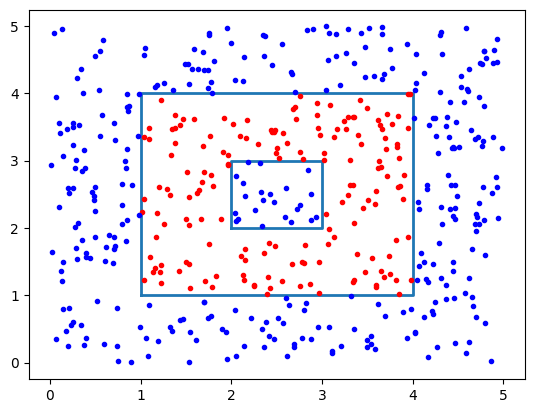

In [241]:
from shapely.geometry import Point, Polygon

def inpolygon(point_x, point_y, polygon_x, polygon_y):
    """
    Check if points are inside or on the edge of a polygonal region.

    Args:
        point_x (float or list): X-coordinates of the points to check.
        point_y (float or list): Y-coordinates of the points to check.
        polygon_x (list): X-coordinates of the polygon vertices.
        polygon_y (list): Y-coordinates of the polygon vertices.

    Returns:
        list: A list of boolean values indicating whether each point is inside or on the edge of the polygon.
    """
    # Create a Polygon object from the polygon vertices
    polygon = Polygon(list(zip(polygon_x, polygon_y)))

    # If single point coordinates are provided, convert them into a list
    if isinstance(point_x, (int, float)):
        point_x = [point_x]
        point_y = [point_y]

    # Create Point objects for the input points
    points = [Point(x, y) for x, y in zip(point_x, point_y)]

    # Check if each point is inside or on the edge of the polygon
    # is_inside = [point.within(polygon) for point in points]

    # is_inside = [polygon.contains(point) for point in points]
    is_inside = [polygon.covers(point) for point in points]

    return np.array(is_inside)


xv = np.array([1, 4, 4, 1, 1, 2, 2, 3, 3, 2])
yv = np.array([1, 1, 4, 4, 1, 2, 3, 3, 2, 2])

np.random.seed()  # Use a random seed for default behavior
xq = np.random.rand(500, 1) * 5
yq = np.random.rand(500, 1) * 5

in_ = inpolygon(xq,yq,xv,yv)

xv = np.array([1, 4, 4, 1, 1, np.nan, 2, 2, 3, 3, 2])
yv = np.array([1, 1, 4, 4, 1, np.nan, 2, 3, 3, 2, 2])
plt.plot(xv, yv, linewidth=2)
plt.plot(xq[in_], yq[in_], 'r.')
plt.plot(xq[np.logical_not(in_)], yq[ np.logical_not(in_)], 'b.')

In [142]:
def get_two_room(cfg_path: str = '../cfg/envs/two_room.ini') -> GeometryParams:
    config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
    config.read(cfg_path)
    geometry = get_geometry_params(config)

    # Scale the objects to full width after coords were between -10 and 10
    scale = config.eval('BuildingBoundaries', 'scale')
    # geometry.objects.x = [[scale * x for x in row] for row in geometry.objects.x]
    # geometry.objects.y = [[scale * y for y in row] for row in geometry.objects.y]
    geometry.objects.x *= scale
    geometry.objects.y *= scale

    return geometry


def get_preplay_env(preplay_env_closed_cfg_path: str) -> GeometryParams:
    config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
    config.read(preplay_env_closed_cfg_path)
    datapath = config.eval('ExternalSources', 'paths')
    red_grid = np.load(datapath)[2:-2, 2:-2]
    y_range = config.eval('RoomDimensions', 'y_range', locals={'red_grid': red_grid})
    x_barrier_top_min = (red_grid[y_range // 2, :] == 1).argmax() + 1
    y_barrier_top = np.where(red_grid[:, -1] == 1)[0][-1] + 1
    x_barrier_bot_min = x_barrier_top_min
    y_barrier_bot = np.where(red_grid[:, -1] == 1)[0][0] + 1

    return get_geometry_params(
        config,
        locals={
            'red_grid': red_grid,
            'x_barrier_bot_min': x_barrier_bot_min,
            'x_barrier_top_min': x_barrier_top_min,
            'y_barrier_bot': y_barrier_bot,
            'y_barrier_top': y_barrier_top,
        }
    )


def get_complex_grid(geometry: GeometryParams, res: float) -> np.ndarray: #!
    min_xy, max_xy = geometry.min_xy, geometry.max_xy
    grid_x = np.arange(min_xy, max_xy + res, res)  # Create a Cartesian grid of possible locations over the environment along the x-axis
    grid_y = np.arange(min_xy, max_xy + res, res)  # Create a Cartesian grid of possible locations over the environment along the y-axis

    # Create 2D grids of x and y values
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)

    # Convert Cartesian coordinates to complex numbers
    complex_grid = grid_x + 1j * grid_y

    # Reshape the complex grid into a 1D vector of grid points (x and y values as complex numbers)
    complex_grid = complex_grid.reshape(-1, 1)

    return complex_grid, grid_x, grid_y


def get_geometry_name(config: str | configparser.ConfigParser) -> str:

    if isinstance(config, str):
        cfg = configparser.ConfigParser(allow_no_value=True)
        cfg.read(config)
        config = cfg

    environment_section = config['Environment']
    two_room = environment_section.getboolean('two_room')
    square_room = environment_section.getboolean('square_room')
    inserted_barrier = environment_section.getboolean('inserted_barrier')
    preplay_env_closed = environment_section.getboolean('preplay_env_closed')
    preplay_env_open = environment_section.getboolean('preplay_env_open')

    if two_room:
        return 'two_room'
    elif square_room:
        return 'squared_room'
    elif inserted_barrier:
        return 'inserted_barrier'
    elif preplay_env_open:
        return 'preplay_env_open'
    elif preplay_env_closed:
        return 'preplay_env_closed'


def get_geometry_by_name(geometry_name: str, cfg_path: str) -> tuple[GeometryParams, int]:

    match geometry_name:
        case 'two_room':
            geometry = get_two_room(cfg_path)
            n_textures = geometry.n_polygons + 2
        case 'squared_room':
            geometry = get_geometry_params(cfg_path)
            n_textures = geometry.n_polygons
        case 'inserted_barrier':
            geometry = get_geometry_params(cfg_path)
            n_textures = geometry.n_polygons + 1
        case 'preplay_env_closed' | 'preplay_env_open':
            geometry = get_preplay_env(cfg_path)
            n_textures = geometry.n_polygons
        case _:
            raise ValueError(f"Unsupported geometry name: {geometry_name}")

    return geometry, n_textures

class AbstractBuildingGeometryProcessor(ABC):

    @abstractmethod
    def get_line_identity(self, poly: int, xf: float, xi: float) -> int:
        pass

    def __call__(self, geometry: GeometryParams, complex_grid: np.ndarray):
        foreground_pts = []  # Will be the possible locations from above that are inside buildings
        line_tex = []  # Identity of each line
        dir_ = []  # Direction of each line
        r0 = []  # Starting point of each line
        for poly in range(1, geometry.n_polygons + 1):
            # Create complex vertices for the current polygon
            vertices = np.array(geometry.objects.x[poly - 1, :] + 1j * geometry.objects.y[poly - 1, :])
            vertices = vertices[:geometry.n_vertices[poly - 1]]

            # Find locations inside this building
            in_poly_pts = np.where(inpolygon(complex_grid.real, complex_grid.imag, vertices.real, -vertices.imag))

            # Locations inside this building, foreground in the sense of looking at the map from above
            # The ground is background, buildings are foreground
            foreground_pts.extend(in_poly_pts[0])

            # Loop over "lines" of the building (same as # of vertices)
            for polyline in range(geometry.n_vertices[poly - 1] - 1):
                xi, xf = geometry.objects.x.T[polyline:polyline + 2, poly - 1]
                yi, yf = geometry.objects.y.T[polyline:polyline + 2, poly - 1]
                line_tex.append(self.get_line_identity(poly, xf, xi))

                dir_.append([xf - xi, yf - yi, 0])  # Line vectors, from one vertex of a building to the next
                r0.append([xi, yi, 0])  # Line start

        return np.array(foreground_pts), np.array(line_tex), np.array(dir_), np.array(r0)


class StandartBuildingGeometryProcessor(AbstractBuildingGeometryProcessor):
    def __init__(self, geometry_name: str):
        if geometry_name not in (
            'two_room',
            'squared_room',
            'inserted_barrier',
            'preplay_env_open',
            'preplay_env_closed'
        ):
            raise NotImplementedError(f'Invalid geometry name: {geometry_name}')

        self.geometry_name = geometry_name

    def get_line_identity(self, poly: int, xf: float, xi: float) -> int:
        match self.geometry_name:
            case 'two_room':
                if poly >= 3 or (poly == 2 and xf > 0 and xi > 0):
                    return poly + 1
                else:
                    return poly
            case 'squared_room' | 'preplay_env_open' | 'preplay_env_closed':
                return poly
            case 'inserted_barrier':
                if poly >= 5 or (poly == 5 and (xf == 14 and xi == 8 or xf == 8 and xi == 14)):
                    return poly + 1
                else:
                    return poly

@dataclass
class TrainingSpace: #!
    coords: Coordinates2D
    identities: np.ndarray
    directions: np.ndarray
    starting_points: np.ndarray
    resolution: float

    def __post_init__(self):
        if self.directions.shape != self.starting_points.shape:
            raise ValueError(
                'directions and starting_points must have the same shape, '
                f'got {self.directions.shape} and {self.starting_points.shape} instead'
            )
        if len(self.identities) != len(self.directions):
            raise ValueError(
                'identities and directions must have the same length, '
                f'got {len(self.identities)} and {len(self.directions)} instead'
            )
    def plot(self, ax: plt.Axes = None, *args, **kwargs) -> plt.Figure | None:
        if not len(args) and not len(kwargs):
            args = 's',
            kwargs = dict(color='tab:gray')
        if ax is not None:
            ax.plot(self.coords.x, self.coords.y, *args, **kwargs)
        else:
            fig, ax = plt.subplots()
            ax.plot(self.coords.x, self.coords.y, *args, **kwargs)
            return fig


def process_training_space(
    geometry: GeometryParams,
    res: float,
    building_geometry_processor: AbstractBuildingGeometryProcessor,
    *args, **kwargs
) -> TrainingSpace:
    # Get the complex grid
    complex_grid, grid_x, grid_y = get_complex_grid(geometry, res)

    # Process building geometry
    building_geometry_processor = building_geometry_processor(*args, **kwargs)
    foreground_pts, line_tex, dir_, r0 = building_geometry_processor(geometry, complex_grid)

    # Create background_x and background_y based on grid_x and grid_y
    background_x = grid_x.copy()
    shape = background_x.shape
    background_x = background_x.T.reshape(-1)
    background_y = grid_y.copy()
    background_y = background_y.T.reshape(-1)

    # Convert the elements which lie within the buildings into non-numbers (NaN)
    background_x[foreground_pts] = np.nan
    background_y[foreground_pts] = np.nan

    # Reshape background_x and background_y
    background_x = background_x.reshape(shape[::-1]).T
    background_y = background_y.reshape(shape[::-1]).T

    # Remove the non-numbers (NaN) from the arrays - forms a column vector
    background_x = background_x.T[np.isfinite(background_x).T]
    background_y = background_y.T[np.isfinite(background_y).T]

    # Find the indices of locations outside of objects, but inside training rect.
    train_ind = np.where(
        (background_x > geometry.min_train.x) &
        (background_x < geometry.max_train.x) &
        (background_y > geometry.min_train.y) &
        (background_y < geometry.max_train.y)
    )[0]


    # Extract the coordinates within the specified range
    train_x = background_x[train_ind]
    train_y = background_y[train_ind]

    return TrainingSpace(Coordinates2D(train_x, train_y), line_tex, dir_, r0, res)


@dataclass
class Boundary:
    coords: Coordinates2D
    textures: np.ndarray

    def __post_init__(self):
        if self.coords.x.shape != self.coords.y.shape:
            raise ValueError(f'x and y must have the same shape, got {self.coords.x.shape} and {self.coords.y.shape} instead')
        if len(self.coords.x) != len(self.textures):
            raise ValueError(f'points and textures must have the same length, got {len(self.coords.x)} and {len(self.textures)} instead')


def process_boundary(training_space: TrainingSpace) -> Boundary:
    total_lines = len(training_space.identities)

    boundary_len = np.linalg.norm(training_space.directions, axis=1)
    Dir_unit = training_space.directions / boundary_len[:, np.newaxis]
    boundary_len[np.where(np.isclose(boundary_len % training_space.resolution, 0))[0]] += training_space.resolution

    boundary_points_x = []
    boundary_points_y = []
    boundary_textures = []

    for boundary in range(total_lines):
        x = training_space.starting_points[boundary, 0] + np.arange(0, boundary_len[boundary], training_space.resolution) * Dir_unit[boundary, 0]
        y = training_space.starting_points[boundary, 1] + np.arange(0, boundary_len[boundary], training_space.resolution) * Dir_unit[boundary, 1]

        boundary_points_x.extend(x.tolist())
        boundary_points_y.extend(y.tolist())
        boundary_textures.extend(np.full(len(x), training_space.identities[boundary]))

    boundary_points_x = np.array(boundary_points_x)
    boundary_points_y = np.array(boundary_points_y)
    boundary_textures = np.array(boundary_textures)

    return Boundary(Coordinates2D(boundary_points_x, boundary_points_y), boundary_textures)


## Initialize room pre play file

In [200]:
np.save('../data/room/roomGridPrePlay', np.heaviside(np.random.normal(0, 1, (40, 40)), 0))

In [6]:
from scipy.io import loadmat
mat = loadmat('../data/room/roomGridPrePlay.mat')
np.save('../data/room/roomGridPrePlay', mat['roomGridPrePlay'])

## Main script

In [234]:
# Create a configparser object
config = configparser.ConfigParser()

# Read the INI file
config.read('../cfg/envs/wts.ini')  # Replace 'your_ini_file.ini' with the actual file path

# Access the variables
flags_section = config['Flags']
GEOMflag = flags_section.getboolean('GEOMflag')
MTLflag = flags_section.getboolean('MTLflag')
HDflag = flags_section.getboolean('HDflag')
TRflag = flags_section.getboolean('TRflag')

environment_section = config['Environment']
two_room = environment_section.getboolean('two_room')
square_room = environment_section.getboolean('square_room')
inserted_barrier = environment_section.getboolean('inserted_barrier')
preplay_env_closed = environment_section.getboolean('preplay_env_closed')
preplay_env_open = environment_section.getboolean('preplay_env_open')
geometry_name = get_geometry_name(config)


params_section = config['Parameters']
namestrg = params_section['namestrg']
res = params_section.getfloat('res')


cfg_dir = '../cfg/envs/'
two_room_cfg = os.path.join(cfg_dir, 'two_room.ini')
square_room_cfg = os.path.join(cfg_dir, 'square_room.ini')
inserted_barrier_cfg = os.path.join(cfg_dir, 'inserted_barrier.ini')
preplay_env_closed_cfg = os.path.join(cfg_dir, 'preplay_env_closed.ini')
preplay_env_open_cfg = os.path.join(cfg_dir, 'preplay_env_open.ini')

In [8]:
def compute_intersection(point1_start: np.ndarray, point2_start: np.ndarray, direction1: np.ndarray, direction2: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    # Calculate how far along each line two lines intersect.

    cross_product = np.cross(direction1, direction2)  # Cross product of direction1 and direction2
    nan_indices = np.where(cross_product == 0)[0]
    if len(nan_indices):
        cross_product[nan_indices] = np.nan
    den1 = -cross_product

    alpha2 = np.cross(point2_start - point1_start, direction1) / cross_product
    alpha1 = np.cross(point1_start - point2_start, direction2) / den1
    # print(alpha2)/

    # Extract the third component (z) from alpha1 and alpha2
    alpha1 = alpha1[:, 2]
    alpha2 = alpha2[:, 2]

    return alpha1, alpha2


compute_intersection(
    np.array([[0, 0, 0]]),
    np.array([[-1, 1, -1]]),
    np.array([[1, 2, 3]]),
    np.array([[4, 5, 6]])
)

(array([3.]), array([1.]))

In [247]:
GEOMflag = True
# geometry_name = 'two_room'
# cfg_path = two_room_cfg
# geometry_name = 'squared_room'
# cfg_path = square_room_cfg
geometry_name = 'inserted_barrier'
cfg_path = inserted_barrier_cfg
# geometry_name = 'preplay_env_closed'
# cfg_path = preplay_env_closed_cfg
# geometry_name = 'preplay_env_open'
# cfg_path = preplay_env_open_cfg
geometry, n_textures = get_geometry_by_name(geometry_name, cfg_path)
training_space = process_training_space(geometry, res, StandartBuildingGeometryProcessor, geometry_name)
boundary = process_boundary(training_space)

In [248]:
training_space.coords.x.shape

(5329,)

In [230]:
print(f'{geometry.max_xy = }')
print(f'{geometry.min_xy = }')
print(f'{geometry.min_train.x = }')
print(f'{geometry.min_train.y = }')
print(f'{geometry.max_train.x = }')
print(f'{geometry.max_train.y = }')
print(f'{geometry.max_n_obj_points = }')
print(f'{geometry.n_objects = }')
print(f'{geometry.n_polygons = }')
print(f'{geometry.n_vertices = }')
print(f'{geometry.objects.x = }')
print(f'{geometry.objects.y = }')

geometry.max_xy = 22
geometry.min_xy = 0
geometry.min_train.x = 0.0
geometry.min_train.y = 0.0
geometry.max_train.x = 21
geometry.max_train.y = 22
geometry.max_n_obj_points = 5
geometry.n_objects = 4
geometry.n_polygons = 4
geometry.n_vertices = array([5, 5, 5, 5])
geometry.objects.x = array([[ 1, 21, 21,  1,  1],
       [21, 22, 22, 21, 21],
       [ 1, 21, 21,  1,  1],
       [ 0,  1,  1,  0,  0]])
geometry.objects.y = array([[21, 21, 22, 22, 21],
       [ 1,  1, 21, 21,  1],
       [ 0,  0,  1,  1,  0],
       [ 1,  1, 21, 21,  1]])


In [252]:
boundary.coords.y.shape

(618,)

In [250]:
print(f'{boundary.coords.x = }')
print(f'{boundary.coords.y = }')
print(f'{boundary.textures = }')


boundary.coords.x = array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ,
        4.3,  4.6,  4.9,  5.2,  5.5,  5.8,  6.1,  6.4,  6.7,  7. ,  7.3,
        7.6,  7.9,  8.2,  8.5,  8.8,  9.1,  9.4,  9.7, 10. , 10.3, 10.6,
       10.9, 11.2, 11.5, 11.8, 12.1, 12.4, 12.7, 13. , 13.3, 13.6, 13.9,
       14.2, 14.5, 14.8, 15.1, 15.4, 15.7, 16. , 16.3, 16.6, 16.9, 17.2,
       17.5, 17.8, 18.1, 18.4, 18.7, 19. , 19.3, 19.6, 19.9, 20.2, 20.5,
       20.8, 21. , 21. , 21. , 21. , 21. , 20.7, 20.4, 20.1, 19.8, 19.5,
       19.2, 18.9, 18.6, 18.3, 18. , 17.7, 17.4, 17.1, 16.8, 16.5, 16.2,
       15.9, 15.6, 15.3, 15. , 14.7, 14.4, 14.1, 13.8, 13.5, 13.2, 12.9,
       12.6, 12.3, 12. , 11.7, 11.4, 11.1, 10.8, 10.5, 10.2,  9.9,  9.6,
        9.3,  9. ,  8.7,  8.4,  8.1,  7.8,  7.5,  7.2,  6.9,  6.6,  6.3,
        6. ,  5.7,  5.4,  5.1,  4.8,  4.5,  4.2,  3.9,  3.6,  3.3,  3. ,
        2.7,  2.4,  2.1,  1.8,  1.5,  1.2,  1. ,  1. ,  1. ,  1. , 21. ,
       21.3, 21.6, 21.9, 22. , 

In [156]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [239]:
training_space.coords.x

array([ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,
        0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,
        0.6,  0.6,  0.6,  0.9,  0.9,  0.9,  0.9,  0

In [222]:
training_space.coords.x[5114], training_space.coords.y[5114]

(21.0, 0.3)

In [225]:
training_space.coords.x[5114] < geometry.max_train.x

False

In [9]:
GEOMflag = True
# geometry_name = 'two_room'
# cfg_path = two_room_cfg
geometry_name = 'squared_room'
cfg_path = square_room_cfg
# geometry_name = 'inserted_barrier'
# cfg_path = inserted_barrier_cfg
# geometry_name = 'preplay_env_closed'
# cfg_path = preplay_env_closed_cfg
# geometry_name = 'preplay_env_open'
# cfg_path = preplay_env_open_cfg

if GEOMflag:
    geometry, n_textures = get_geometry_by_name(geometry_name, cfg_path)
    training_space = process_training_space(geometry, res, StandartBuildingGeometryProcessor, geometry_name)
    boundary = process_boundary(training_space)

    num_bndry_pts = boundary.coords.x.shape[0]
    total_lines = len(training_space.identities)
    bpone = np.ones(num_bndry_pts)  # Helper arrays
    bpzero = np.zeros(num_bndry_pts)  # Helper arrays
    NTrainPts =  training_space.coords.x.shape[0]# Replace with the actual number of training points
    VisXY = np.full((2, num_bndry_pts, NTrainPts), np.nan)  # Initialize VisXY with NaN values
    Texture = np.full((NTrainPts, num_bndry_pts), np.nan)  # Initialize Texture with NaN values
    # Initialize variables and arrays
    TrainingLoc = np.zeros((NTrainPts, 2))
    occluded_pts = np.zeros(num_bndry_pts, dtype=bool)
    unocc_ind = np.empty(0, dtype=int)

    # Loop over training locations
    for location in range(NTrainPts):

        posx = training_space.coords.x[location]
        posy = training_space.coords.y[location]
        TrainingLoc[location] = [posx, posy]  # Store current training location

        local_r0 = training_space.starting_points - np.array([posx, posy, 0])  # Transform boundary coordinates relative to current location
        Loc_bndry_pts = np.column_stack((boundary.coords.x - posx, boundary.coords.y - posy, bpzero))

        occluded_pts.fill(False)  # Reset occluded_pts array

        # Loop to determine occluded boundary points
        for occ_bndry in range(total_lines):
            alpha_pt, alpha_occ = compute_intersection(
                np.zeros((num_bndry_pts, 3)),
                np.expand_dims(local_r0[occ_bndry], 0),
                Loc_bndry_pts,
                np.expand_dims(training_space.directions[occ_bndry], 0)
            )  # Calculate alpha values
            # print(
            #     np.zeros((num_bndry_pts, 3)).shape,
            #     local_r0[occ_bndry].shape,
            #     Loc_bndry_pts.shape,
            #     training_space.directions[occ_bndry].shape
            # )
            # raise
            if not np.all(np.isnan(alpha_pt)) or not np.all(np.isnan(alpha_occ)):
                raise
            occluded_pts |= (alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ <= 1) & (alpha_occ >= 0)  # Accumulate occluded points
        print(np.all(np.logical_not(occluded_pts)))
        # Find unoccluded boundary points
        unocc_ind = np.where(~occluded_pts)[0]

        # Calculate the number of visible points
        num_vis_pts = unocc_ind.size

        # Populate VisXY and Texture arrays
        VisXY[:, :num_vis_pts, location] = Loc_bndry_pts[unocc_ind, :2].T + np.array([posx, posy])[:, np.newaxis]
        Texture[location, :num_vis_pts] = boundary.textures[unocc_ind].T


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [736]:
Texture.shape

(4093, 650)

In [737]:
Texture[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [698]:
boundary.textures.shape, boundary.points.x.shape, boundary.points.y.shape

((650,), (650,), (650,))